In [3]:
# Importing all required packages (costume script is included in the same directory)
from NbodyTTV import twoPlanetTTV
import corner
import batman as bm
import numpy as np
from matplotlib import pyplot as plt
import time
import matplotlib as mpl
from tqdm import trange

In [4]:
mpl.rcParams['figure.dpi'] = 300

In [6]:
# Setting up random seeds
np.random.seed(42)

# Preliminary assumptions / expectations of some parameters
global Ms # host star mass
Ms = 1

global Mp1 # ratio between two planets in our system
Mp1 = 1

global Tp1 # transit period in days
Tp1 = 10

In [7]:
# Defining a function for getting the OC curve
def get_oc(pars, ts):
    pars = np.array(pars, dtype=float)

    m0 = Ms
    m1 = Mp1
    m2 = Mp1 / pars[0]
    T1 = Tp1
    T2 = pars[1]
    e1 = 0
    e2 = pars[2]
    w1 = 0
    w2 = pars[3]

    ts = twoPlanetTTV(m0, m1, m2,
                      T1, T2, e1, e2, w1, w2, Ntransits=ts)

    periods = np.diff(ts)

    expected = [ts[0] + np.mean(periods) * n for n in range(len(ts))]

    OC = ts - expected

    return OC*24*60

In [8]:
# Defining function for getting the chi2 value back
def chisq(pars, data, ts, Ninv):

    if pars[2] < 0:
        return np.inf

    y = get_oc(pars, ts)
    r = data-y
    chisq = r@Ninv@r
    return chisq

In [42]:
# This cell shows the main body and process of the MCMC chain
def run_chain(pars, fun, data, ts, Ninv, L, nsamp=100, adapt_steps=110, target_acceptance=0.28):
    chisq = np.zeros(nsamp)
    npar = len(pars)
    chain = np.zeros([nsamp, npar])
    chain[0, :] = pars
    chisq[0] = fun(pars, data, ts, Ninv)
    acceptance_count = 0  # Track acceptance count
    step_size = L  # Initialize step size

    for i in trange(1, nsamp):
        pnew = chain[i - 1, :] + step_size * np.random.randn(npar)
        chi_new = fun(pnew, data, ts, Ninv)
        prob = np.exp(0.5 * (chisq[i - 1] - chi_new))

        if np.random.rand(1)[0] < prob:  # Accept step
            chain[i, :] = pnew
            chisq[i] = chi_new
            acceptance_count += 1
        else:  # Reject step
            chain[i, :] = chain[i - 1, :]
            chisq[i] = chisq[i - 1]

        # Adjust step size every `adapt_steps` iterations
        if i % adapt_steps == 0:
            acceptance_rate = acceptance_count / adapt_steps
            # print(acceptance_rate)
            if acceptance_rate < target_acceptance:
                step_size *= 0.8  # Decrease step size
            elif acceptance_rate > target_acceptance:
                step_size *= 1.2  # Increase step size
            acceptance_count = 0  # Reset acceptance count

    return chain, chisq

In [43]:
# Initializing the OC curve from previous MCMC and other parameters
OC = np.genfromtxt('OC_curve_from_mcmc.txt')
data = OC[:, 0]
errs = OC[:, 1]
ts = len(data)

In [44]:
# set initial parameters
titles = ['Mp1 / Mp2', 'Tp2', 'ecc2', 'omega2']
real = np.asarray([1,    160, 0.2, np.pi/6])
pguess = np.asarray([2,  200, 0.0, 0])  # input

# The perturbation that we are applying to the process (need some manual addition for the 3rd and 4th parameters)
L = pguess*1e-3
L[2] = L[2] + 1e-3
L[3] = L[3] + 1e-3

Ninv = np.diag(1/errs**2)

In [45]:
nsamp = 75000
burnin = 20000


chain, chivec = run_chain(pguess, chisq, data, ts, Ninv,
                          L=L, nsamp=nsamp)
chain = chain[burnin:, :]
chivec = chivec[burnin:]

100%|███████████████████████████████████████████████████| 74999/74999 [05:40<00:00, 220.46it/s]


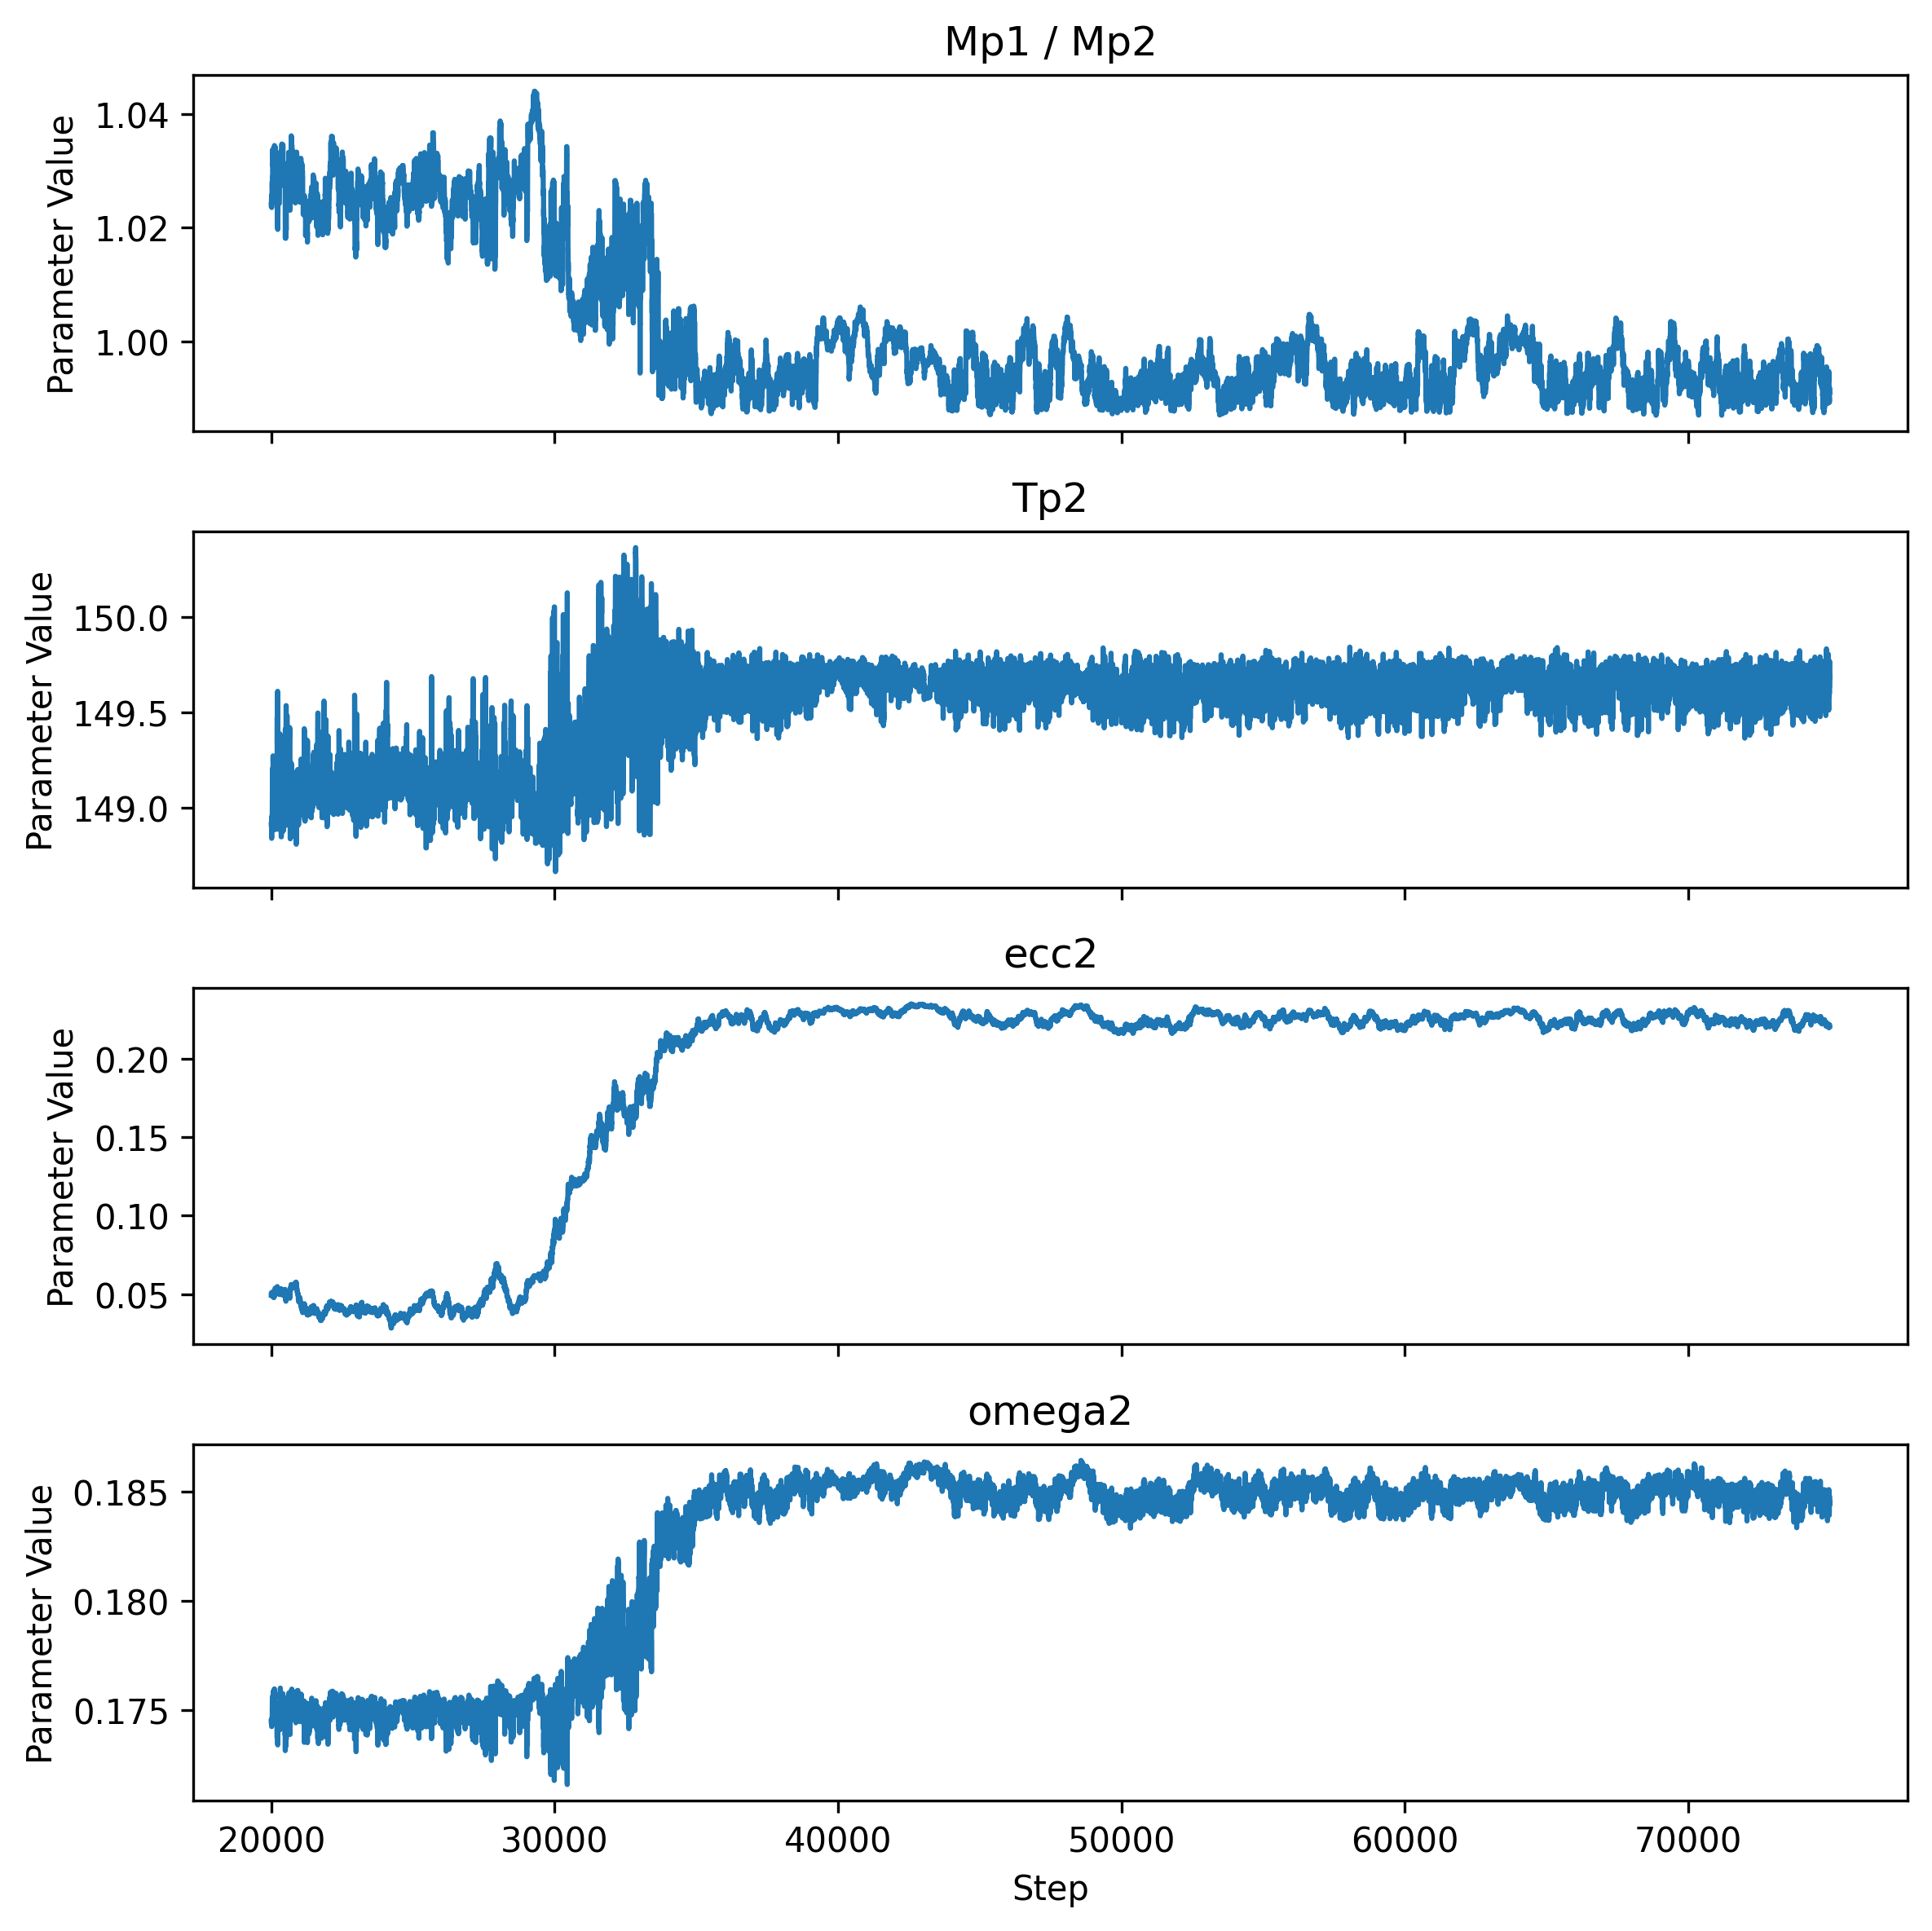

[  1.     160.       0.2      0.5236]
[  1.00163 149.52667   0.18731   0.1826 ]


In [46]:
steps = np.arange(0, nsamp)
steps = steps[burnin:]
# Number of parameters
n_params = len(titles)

# Create a figure and subplots stacked vertically
fig, axes = plt.subplots(n_params, 1, figsize=(8, 2 * n_params), sharex=True)

# Plot each parameter chain on its corresponding subplot
for i, ax in enumerate(axes):
    ax.plot(steps, chain[:, i])  # Plot for the i-th parameter
    ax.set_title(titles[i])
    ax.set_ylabel("Parameter Value")

# Label the x-axis only on the bottom plot
axes[-1].set_xlabel("Step")

# Adjust the layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()

np.set_printoptions(precision=5, suppress=True)
print(real)
print(np.mean(chain, axis=0))

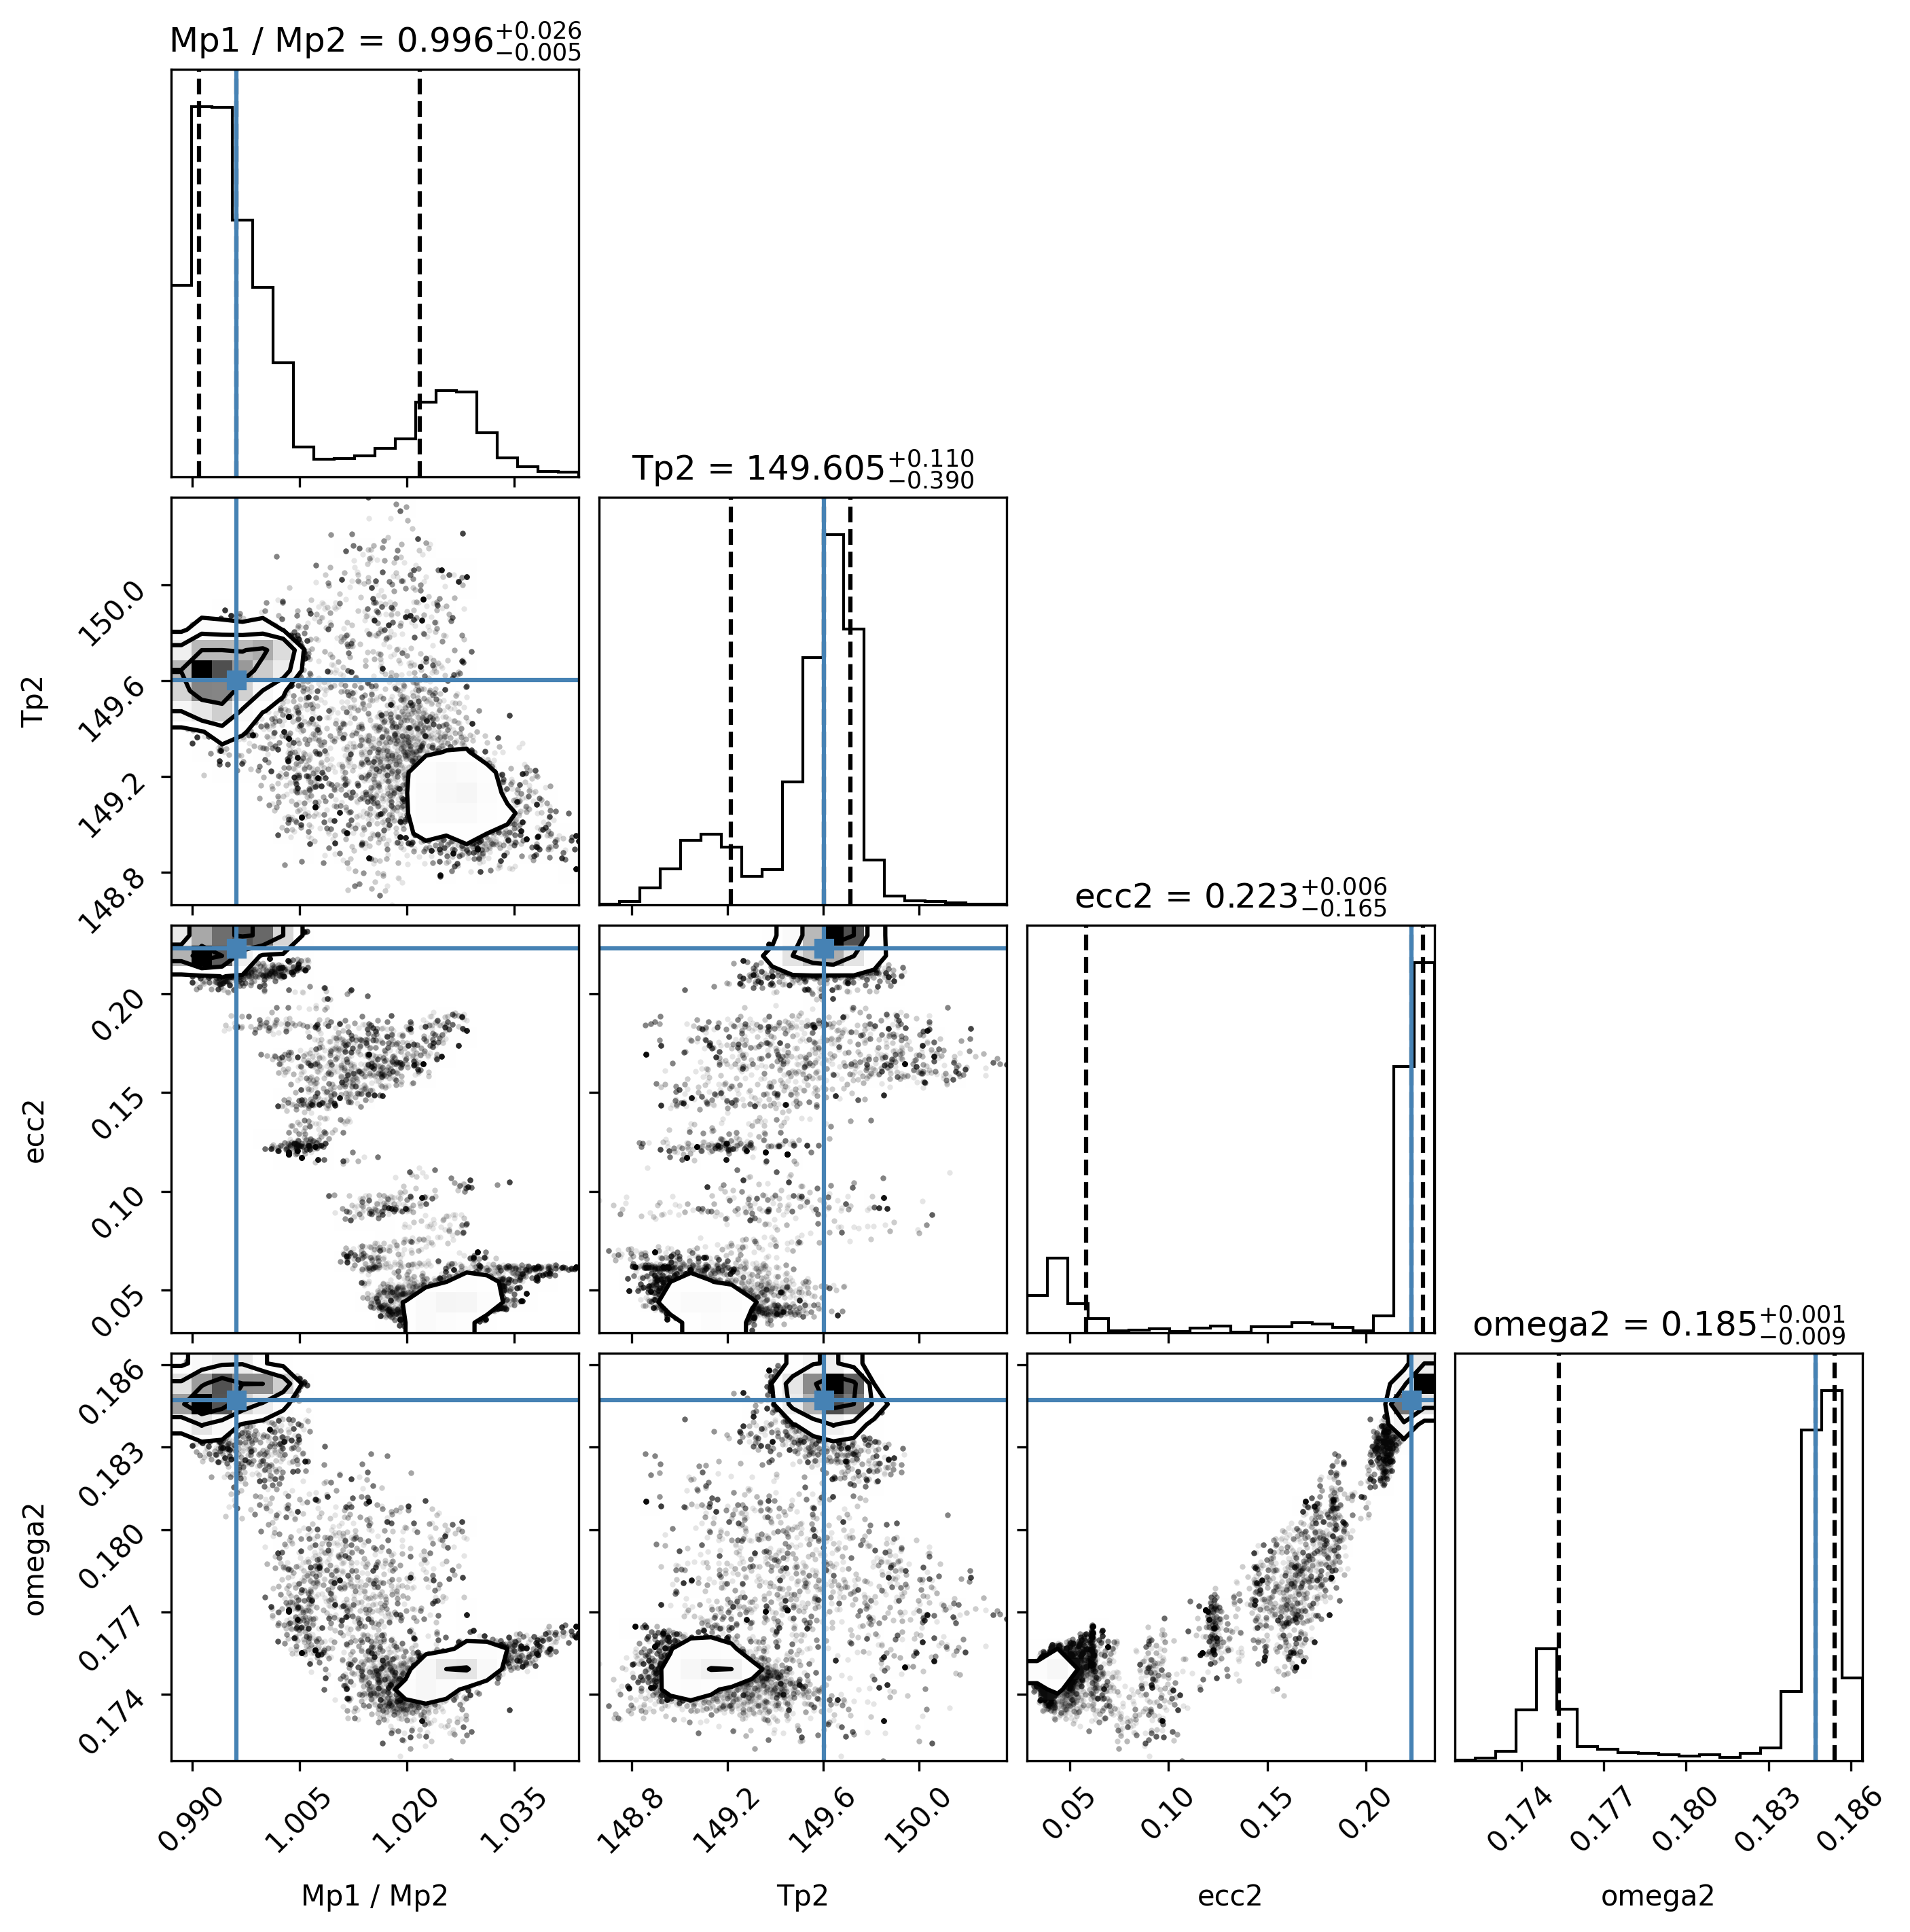

In [47]:
# Create a corner plot
fig = corner.corner(chain, labels=titles, truths=np.median(
    chain, axis=0), quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='.3f', )

# Show the plot
plt.show()

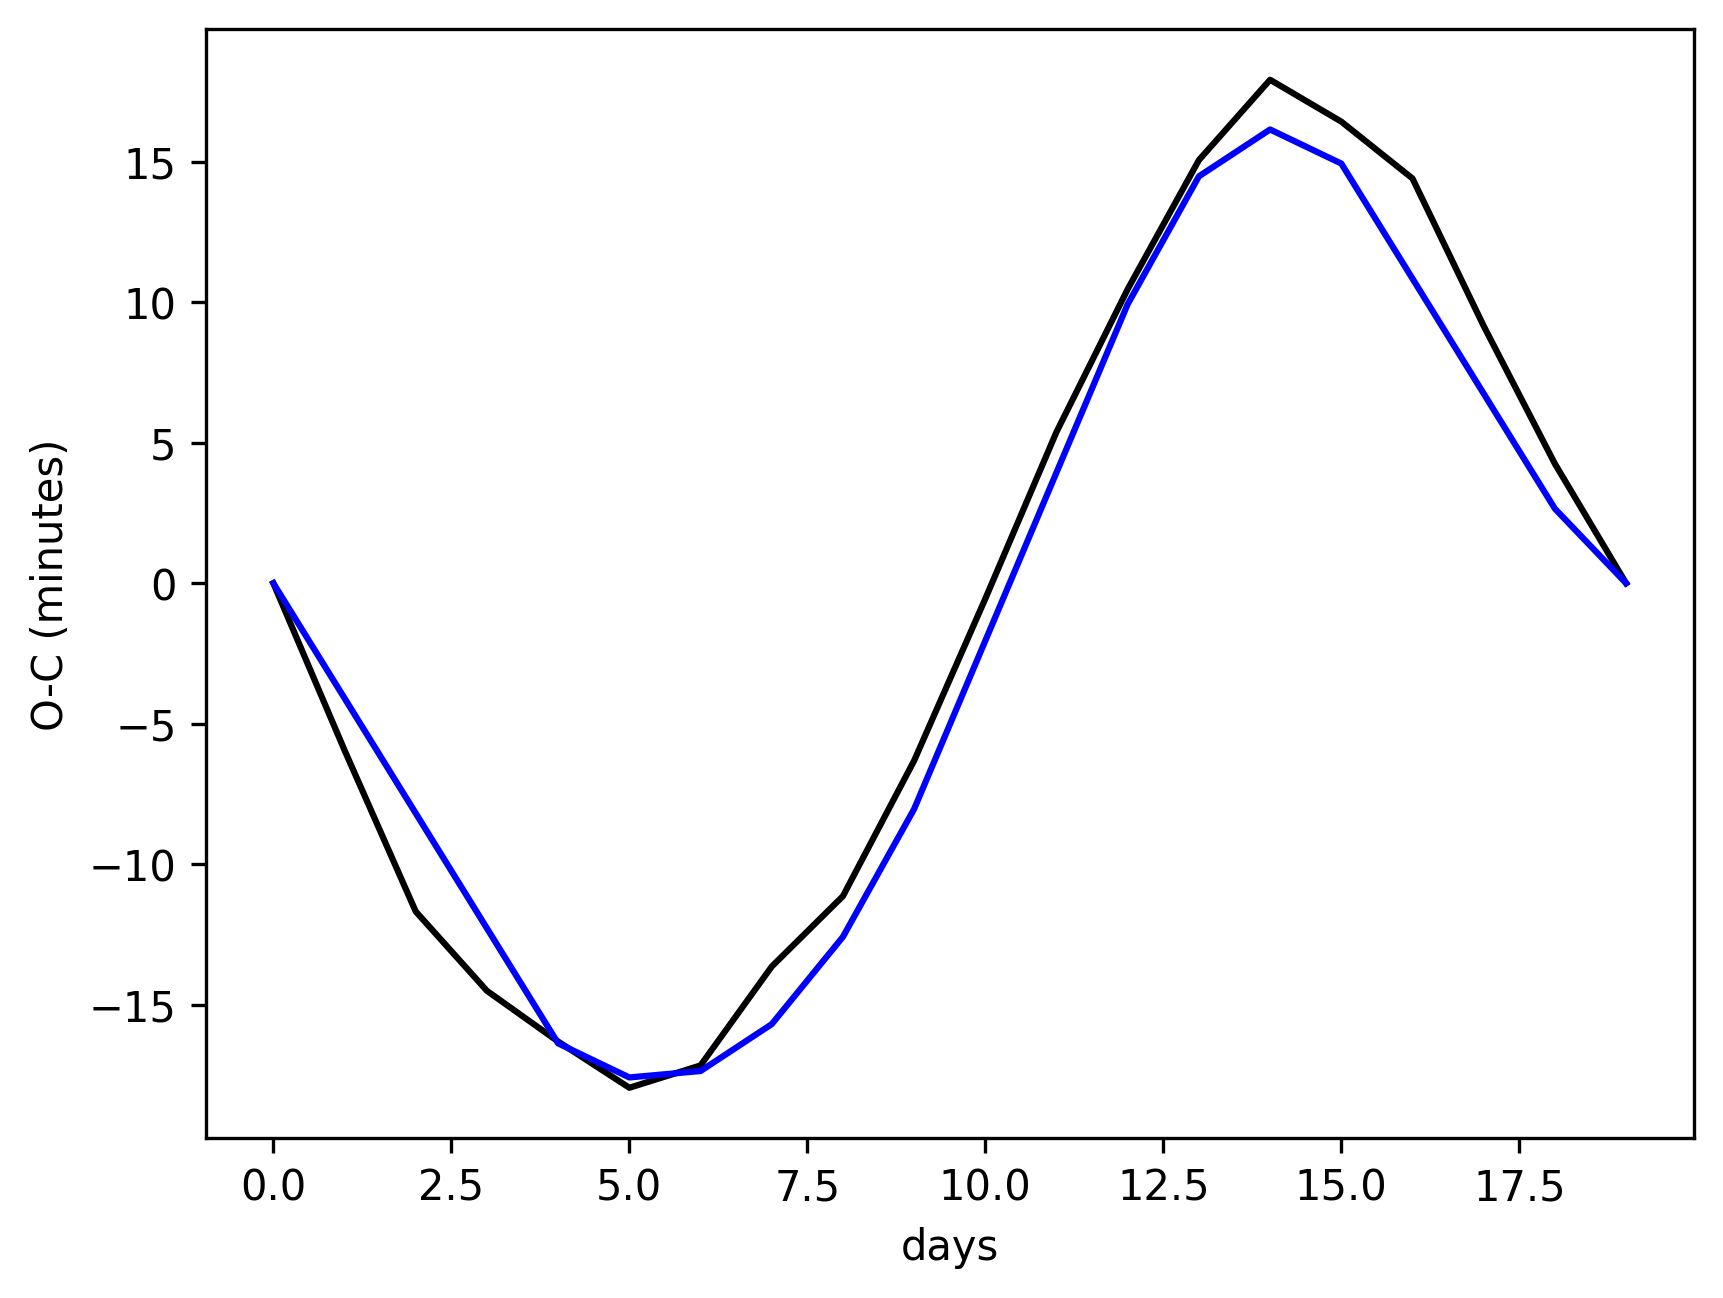

In [48]:
fit = get_oc(np.mean(chain, axis=0), ts)
plt.plot(data, c='k', label='Data')
plt.plot(fit, c='blue', label='MCMC fit')
plt.xlabel("days")
plt.ylabel("O-C (minutes)")
plt.show()